In [15]:

import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

import qiskit
provider = qiskit.IBMQ.load_account()


import numpy as np

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CobylaOptimizer, MinimumEigenOptimizer

from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from matplotlib import pyplot as plt
%matplotlib inline

from multiprocessing import Process, Value, Array
import multiprocessing as mp

ibmqfactory.load_account:WARNING:2021-08-20 16:24:35,093: Credentials are already in use. The existing account in the session will be replaced.


In [16]:
quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS)


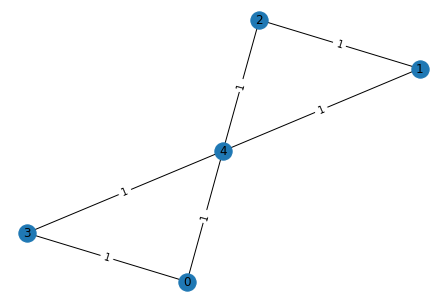

In [17]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [18]:
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)


In [19]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)

In [20]:
def run_qaoa(gamma, beta):
    quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS)
    qaoa = QAOA(optimizer=COBYLA(maxiter=0),
                quantum_instance=quantum_instance,
                reps=1,
                initial_point=[gamma, beta])
    
    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True,
                                 qaoa=qaoa)
    
    
    result = qaoa.solve(max_cut_problem)
    
    #algorithm = MinimumEigenOptimizer(qaoa)
    #result = algorithm.solve(max_cut_qubo)
    #optimal_parameters = qaoa.optimal_params
    mean, distribution = max_cut.analyse(result)

    return mean

In [7]:
def run_qaoa_process(arr, index, gamma, beta):
    print("sdf")
    mean = run_qaoa(gamma, beta)
    print(f"mean {mean}")
    arr[index] = mean

In [8]:
mp.freeze_support()
ctx = mp.get_context('spawn')


In [21]:
import ibm_landscape_processes
F1 = ibm_landscape_processes.run_all(a_gamma, b_beta, max_cut)

Row 0
Row 1
Row 2
Row 3
Row 4
Row 5
Row 6
Row 7
Row 8
Row 9
Row 10
Row 11
Row 12
Row 13
Row 14
Row 15
Row 16
Row 17
Row 18
Row 19
Row 20
Row 21
Row 22
Row 23
Row 24
Row 25
Row 26
Row 27
Row 28
Row 29
Row 30
Row 31


In [22]:
print(F1)

[[-2.98049998 -3.01399994 -3.01850009 ... -2.99874997 -3.02125001
  -2.98200011]
 [-3.0002501  -2.88549995 -2.77624989 ... -3.25375009 -3.14450002
  -3.06424999]
 [-3.01224995 -2.75       -2.55375004 ... -3.44125009 -3.29775
  -3.11100006]
 ...
 [-3.00749993 -3.24825001 -3.47125006 ... -2.37975001 -2.61074996
  -2.88474989]
 [-3.00449991 -3.19575    -3.28550005 ... -2.6312499  -2.77125001
  -2.92475009]
 [-2.9855001  -3.02399993 -3.10800004 ... -2.898      -2.93175006
  -2.97600007]]


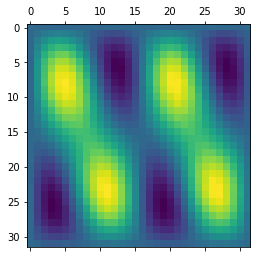

In [23]:
plt.matshow(F1)
plt.show()

In [9]:
F1 = np.zeros(a_gamma.shape)
for i in range(0, len(F1)):
    processes = []
    arr = ctx.Array('f', range(len(a_gamma)))
    for j in range(0, len(F1)):
        # F1[i,j] = a_gamma[i][j] * b_beta[i][j]
        p = ctx.Process(target=run_qaoa_process, args=(arr, j, a_gamma[i][j], b_beta[i][j]))
        p.start()
        processes.append(p)
        print("started Processes")
    
    for pp in processes:
        print("joined Processes")
        pp.join()
    print(arr[:])
    for j in range(0,len(arr)):
        print(f"m {arr[j]} {j}")
        #F1[i,j] = m

started Processes
started Processes
started Processes
started Processes
joined Processes
joined Processes
joined Processes
joined Processes
[0.0, 1.0, 2.0, 3.0]
m 0.0 0
m 1.0 1
m 2.0 2
m 3.0 3


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_se

started Processes
started Processes
started Processes
started Processes
joined Processes
joined Processes
joined Processes
joined Processes
[0.0, 1.0, 2.0, 3.0]
m 0.0 0
m 1.0 1
m 2.0 2
m 3.0 3


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_se

started Processes
started Processes
started Processes
started Processes
joined Processes
joined Processes
joined Processes
joined Processes
[0.0, 1.0, 2.0, 3.0]
m 0.0 0
m 1.0 1
m 2.0 2
m 3.0 3


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_se

started Processes
started Processes
started Processes
started Processes
joined Processes
joined Processes
joined Processes
joined Processes
[0.0, 1.0, 2.0, 3.0]
m 0.0 0
m 1.0 1
m 2.0 2
m 3.0 3


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'run_qaoa_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib64/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_se

In [36]:
F1 = np.zeros(a_gamma.shape)
for i in range(0, len(F1)):
    for j in range(0, len(F1)):
        # F1[i,j] = a_gamma[i][j] * b_beta[i][j]
        F1[i,j] = run_qaoa(a_gamma[i][j], b_beta[i][j])

[[-2.99425 -3.01475 -3.02125 -2.98725]
 [-2.965   -2.8755  -1.30225 -3.46475]
 [-3.019   -1.43675 -3.1775  -2.48625]
 [-3.00275 -2.6445  -3.36875 -2.79125]]


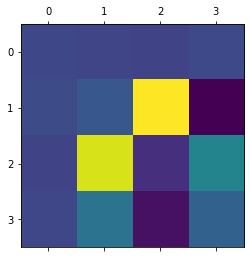

In [37]:
print(F1)
plt.matshow(F1)
plt.show()

In [24]:
np.mean(F1)

-2.6388437491841614

In [32]:
F1

array([[-2.984  , -2.99675, -2.97925, -2.99625],
       [-2.993  , -2.8575 , -1.332  , -3.4685 ],
       [-3.00425, -1.43075, -3.172  , -2.4985 ],
       [-2.985  , -2.65175, -3.38525, -2.7825 ]])

In [25]:
F2 = F1 - np.mean(F1)

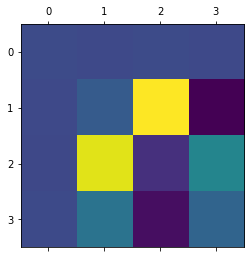

In [26]:
plt.matshow(F2)
plt.show()

In [27]:
F2

array([[-2.01671875e-01, -2.14421875e-01, -1.96921875e-01,
        -2.13921875e-01],
       [-2.10671875e-01, -7.51718750e-02,  1.45032812e+00,
        -6.86171875e-01],
       [-2.21921875e-01,  1.35157813e+00, -3.89671875e-01,
         2.83828125e-01],
       [-2.02671875e-01,  1.30578125e-01, -6.02921875e-01,
        -1.71875000e-04]])

In [13]:
np.min(F1)

-3.926500082015991

In [14]:
np.unravel_index(np.argmin(F1), F1.shape)

(25, 3)

In [25]:
np.min(F1)

-3.927999973297119

In [26]:
np.unravel_index(np.argmin(F1), F1.shape)

(25, 19)